# 4.4.2
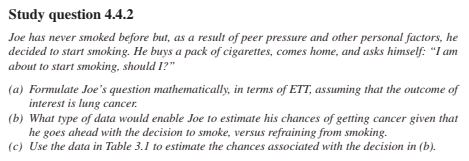
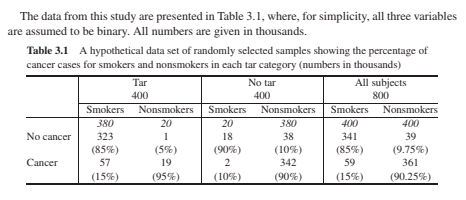

In [1]:
from typing import NamedTuple

class Features(NamedTuple):
    tar: bool
    smoker: bool
    cancer: bool

F = Features
JOINT_COUNTS = {
    # Column 1:
    F(1, 1, 0): 323,
    F(1, 1, 1): 57,
    # Column 2:
    F(1, 0, 0): 1,
    F(1, 0, 1): 19,
    # Column 3:
    F(0, 1, 0): 18,
    F(0, 1, 1): 2,
    # Column 4:
    F(0, 0, 0): 38,
    F(0, 0, 1): 342,
    # Column 5/6: Aggregate data from previous..
}
TOTAL = sum(JOINT_COUNTS.values())
TABLE_3_1 = {k: count / TOTAL for k, count in JOINT_COUNTS.items()}

from typing import *
from collections import defaultdict
def P(*variables: List[str], joint_dist=TABLE_3_1, **given):
    """
    e.g. P("sprinkler", "slippery", wet=0, season=1) = P(sprinkler, slippery|wet=0, season=1)
    
    Returns a joint distribution on the list of variables, given that `given` is the case.
    """
    Event = NamedTuple('Event', [(variable, Any) for variable in variables])
    p_given = 0.0
    conditional_dist = defaultdict(float)
    for event, prob in joint_dist.items():
        if all(getattr(event, k) == v for k, v in given.items()):
            p_given += prob
            c = Event(*[getattr(event, var) for var in variables])
            conditional_dist[c] += prob
    return {
        c: prob / p_given for c, prob in conditional_dist.items()
    }

# Should match the the last two columns:
{event: prob * TOTAL for event, prob in P("smoker", "cancer").items()}

{Event(smoker=1, cancer=0): 341.00000000000006,
 Event(smoker=1, cancer=1): 59.00000000000001,
 Event(smoker=0, cancer=0): 39.00000000000001,
 Event(smoker=0, cancer=1): 361.00000000000006}

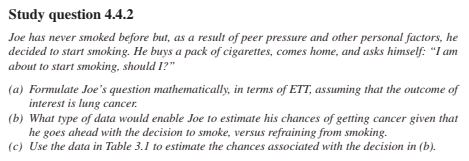
Here we assume the causal model from figure 3.10(b):

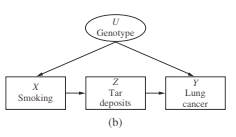

#### Can we use the equations on page 109?

Maybe use the front-door criterion?


From page 68, we have the following (using the front-door criterion):
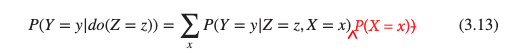
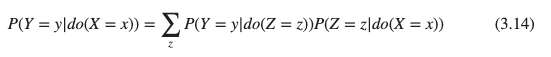
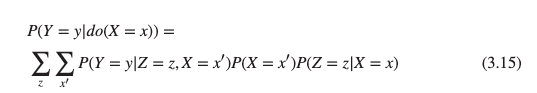

Recall that:
\begin{aligned}
    ETT &= E[Y_1 - Y_0|X=1] \\
        &= E[Y_1|X=1] - E[Y_0|X=1] \\
        &= E[Y|X=1] -  E[Y_0|X=1] \qquad \textrm{by the consistency rule (eqn 4.6)} \\
\end{aligned}

The first term can be estimated from the joint probability distribution above:

In [25]:
def E(var, joint_dist=TABLE_3_1, **given) -> float:
    conditional_dist = P(var, **given, joint_dist=joint_dist)
    return sum(event * prob for ((event, ), prob) in conditional_dist.items())

print(P("cancer", smoker=1))
E_Y_given_X_1 = E("cancer", smoker=1)
print(f"E[Y|X=1]={E_Y_given_X_1}")

{Event(cancer=0): 0.8525, Event(cancer=1): 0.1475}
E[Y|X=1]=0.1475


Now we need to compute $E[Y|do(X=0)]$, and we can use the front-door criterion above (3.15):

In [29]:
def P_front_door(Y: str, Z: str, X: str, do_X=..., joint_dist=TABLE_3_1) -> dict:
    def get_vals(var):
        return {getattr(event, var) for event in joint_dist}
    P_Y_given_do_X = {}
    Event = NamedTuple('Event', [(Y, Any)])
    for y in get_vals(Y):
        acc = 0.0
        for z in get_vals(Z):
            for x_prime in get_vals(X):
                # eqn 3.15 above
                P_Y_y_given_Z_z_X_x_prime = P(Y, **{Z: z, X: x_prime})[(y, )]
                P_X_x_prime = P(X)[(x_prime, )]
                P_Z_z_given_X_x = P(Z, **{X: do_X})[(z,)]
                acc += P_Y_y_given_Z_z_X_x_prime * P_X_x_prime * P_Z_z_given_X_x
        P_Y_given_do_X[Event(y)] = acc
    return P_Y_given_do_X
print(P_front_door(Y="cancer", X="smoker", Z="tar", do_X=0))
print(P("cancer"))
E_Y_given_do_X_0 = E("cancer", joint_dist=P_front_door(Y="cancer", X="smoker", Z="tar", do_X=0))
print(f"{E_Y_given_do_X_0=}")

{Event(cancer=0): 0.49750000000000005, Event(cancer=1): 0.5025000000000001}
{Event(cancer=0): 0.47500000000000003, Event(cancer=1): 0.5250000000000001}
E_Y_given_do_X_0=0.5025000000000001


Now recall Richard's solution to 4.4.1(a):
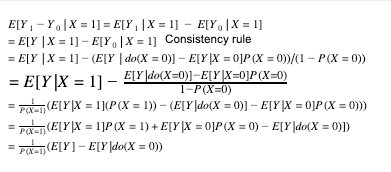

Since the variables are binary, we can apply that formula here:

In [30]:
solution = (1 / P("smoker")[(1, )]) * (E("cancer") - E_Y_given_do_X_0)
print(f"{solution=}")

solution=0.045000000000000144
